In [ ]:
from __future__ import print_function

import sys
import os
import pandas as pd
import numpy as np

from keras.layers import Input, Embedding, LSTM, TimeDistributed, Dense
from keras.models import Model, load_model

from models import encoding

In [ ]:
LEARNING_RATE=0.5
BATCH_SIZE = 64
HIDDEN_NODES = 128
NUMBER_OF_LAYERS = 2
EMB_SIZE=100
EPOCHS=30

In [ ]:
data = pd.read_excel('Rumi-Jawi Parallel corpora.xlsx', header=None, skiprows=1)
# data = pd.read_excel('Arabizi-Arabic Parallel corpora.xlsx', header=None, skiprows=1)
data = data.sample(frac=1, random_state=0)

data_input = [str(s).strip().lower() for s in data[0]]
data_output = [str(s).strip() for s in data[1]]
print(data_input[0], data_output[0])
print(data_input[5], data_output[5])

data_size = len(data)

# We will use the first 0-60th %-tile (60%) of data for the training
range_of_train = int(data_size*60/100)

training_input  = data_input[0: range_of_train ]
training_output = data_output[0: range_of_train ]

# We will use the first 60-70th %-tile (10%) of data for the training
range_of_train = int(data_size*60/100)
range_of_val = int(data_size*70/100)

validation_input = data_input[range_of_train:range_of_val]
validation_output = data_output[range_of_train: range_of_val]

print('total data', len(data))
print('training size', len(training_input))
print('validation size', len(validation_input))

چلاک! چندانا ماسيه دأودارا، تروس مڠهونوس كريس Celaka! Cendana masih di udara, terus menghunus keris
للاكي برڤاروت ايت تنڠ سهاج Lelaki berparut itu tenang sahaja
total data 13573
training size 8143
validation size 1358


In [ ]:
INPUT_LENGTH=0
OUTPUT_LENGTH=0
for i in data_input:
    if len(i)>INPUT_LENGTH:
        INPUT_LENGTH=len(i)
for i in data_output:
    if len(i)>OUTPUT_LENGTH:
        OUTPUT_LENGTH=len(i)
print("max input len=", INPUT_LENGTH,"\nmax output len=",OUTPUT_LENGTH)

max input len= 463 
max output len= 441


## Transform data into Numpy arrays
We transform the sequences of characters into sequences of integer IDs. This will be done by using pre-written functions in encoding module.

First, encoding.build_characters_encoding will build encoding/decoding dictionary from the data.
Then, encoding.transform will transform the data into numpy array.

In [ ]:
input_encoding, input_decoding, input_dict_size = encoding.build_characters_encoding(data_input)
output_encoding, output_decoding, output_dict_size = encoding.build_characters_encoding(data_output)

print('English character dict size:', input_dict_size)
print('Arabic character dict size:', output_dict_size)

encoded_training_input = encoding.transform(
    input_encoding, training_input, vector_size=INPUT_LENGTH)
encoded_training_output = encoding.transform(
    output_encoding, training_output, vector_size=OUTPUT_LENGTH)

print('encoded_training_input', encoded_training_input.shape)
print('encoded_training_output', encoded_training_output.shape)

encoded_validation_input = encoding.transform(
    input_encoding, validation_input, vector_size=INPUT_LENGTH)
encoded_validation_output = encoding.transform(
    output_encoding, validation_output, vector_size=OUTPUT_LENGTH)

print('encoded_validation_input', encoded_validation_input.shape)
print('encoded_validation_output', encoded_validation_output.shape)

English character dict size: 78
Arabic character dict size: 89
encoded_training_input (8143, 463)
encoded_training_output (8143, 441)
encoded_validation_input (1358, 463)
encoded_validation_output (1358, 441)


# Sequence-to-Sequence in Keras

In [ ]:
encoder_input = Input(shape=(INPUT_LENGTH,))
decoder_input = Input(shape=(OUTPUT_LENGTH,))

### Encoder / Decoder


In [ ]:
from keras.layers import SimpleRNN

encoder = Embedding(input_dict_size, EMB_SIZE, input_length=INPUT_LENGTH, mask_zero=True)(encoder_input)
encoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(encoder)
encoder_last = encoder[:,-1,:]

print('encoder', encoder)
print('encoder_last', encoder_last)

decoder = Embedding(output_dict_size, EMB_SIZE, input_length=OUTPUT_LENGTH, mask_zero=True)(decoder_input)
decoder = LSTM(HIDDEN_NODES, return_sequences=True, unroll=True)(decoder, initial_state=[encoder_last, encoder_last])

print('decoder', decoder)

encoder KerasTensor(type_spec=TensorSpec(shape=(None, 463, 128), dtype=tf.float32, name=None), name='lstm/transpose_2:0', description="created by layer 'lstm'")
encoder_last KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")
decoder KerasTensor(type_spec=TensorSpec(shape=(None, 441, 128), dtype=tf.float32, name=None), name='lstm_1/transpose_2:0', description="created by layer 'lstm_1'")


### Attention Mechanism
Reference: <a href="https://arxiv.org/pdf/1508.04025.pdf">Effective Approaches to Attention-based Neural Machine Translation</a>'s Global Attention with Dot-based scoring function (Section 3, 3.1)

In [ ]:
from keras.layers import Activation, dot, concatenate

# Equation (7) with 'dot' score from Section 3.1 in the paper.
# Note that we reuse Softmax-activation layer instead of writing tensor calculation
attention = dot([decoder, encoder], axes=[2, 2])
attention = Activation('softmax', name='attention')(attention)
print('attention', attention)

context = dot([attention, encoder], axes=[2,1])
print('context', context)

decoder_combined_context = concatenate([context, decoder])
print('decoder_combined_context', decoder_combined_context)

# Has another weight + tanh layer as described in equation (5) of the paper
output = TimeDistributed(Dense(HIDDEN_NODES, activation="tanh"))(decoder_combined_context)
output = TimeDistributed(Dense(output_dict_size, activation="softmax"))(output)
print('output', output)

attention KerasTensor(type_spec=TensorSpec(shape=(None, 441, 463), dtype=tf.float32, name=None), name='attention/Softmax:0', description="created by layer 'attention'")
context KerasTensor(type_spec=TensorSpec(shape=(None, 441, 128), dtype=tf.float32, name=None), name='dot_1/MatMul:0', description="created by layer 'dot_1'")
decoder_combined_context KerasTensor(type_spec=TensorSpec(shape=(None, 441, 256), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")
output KerasTensor(type_spec=TensorSpec(shape=(None, 441, 89), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [ ]:
model = Model(inputs=[encoder_input, decoder_input], outputs=[output])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Training the model

In [ ]:
training_encoder_input = encoded_training_input
training_decoder_input = np.zeros_like(encoded_training_output)
training_decoder_input[:, 1:] = encoded_training_output[:,:-1]
training_decoder_input[:, 0] = encoding.CHAR_CODE_START
training_decoder_output = np.eye(output_dict_size)[encoded_training_output.astype('int')]

validation_encoder_input = encoded_validation_input
validation_decoder_input = np.zeros_like(encoded_validation_output)
validation_decoder_input[:, 1:] = encoded_validation_output[:,:-1]
validation_decoder_input[:, 0] = encoding.CHAR_CODE_START
validation_decoder_output = np.eye(output_dict_size)[encoded_validation_output.astype('int')]

In [ ]:
history = None
if os.path.isfile('model.h5'):
    model = load_model('model.h5')
else:
    history = model.fit(x=[training_encoder_input, training_decoder_input], y=training_decoder_output,
          validation_data=([validation_encoder_input, validation_decoder_input], validation_decoder_output),
          verbose=2, batch_size=BATCH_SIZE, epochs=EPOCHS)

# model.fit(x=[training_encoder_input, training_decoder_input], y=[training_decoder_output],
#           validation_data=([validation_encoder_input, validation_decoder_input], [validation_decoder_output]),
#           verbose=2, batch_size=BATCH_SIZE, epochs=30)

model.save('model.h5')

In [ ]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

AttributeError: 'NoneType' object has no attribute 'history'

### Testing the model


In [ ]:
def generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    for i in range(1, OUTPUT_LENGTH):
        output = model.predict([encoder_input, decoder_input]).argmax(axis=2)
        decoder_input[:,i] = output[:,i]
    return decoder_input[:,1:]

def decode(decoding, sequence):
    text = ''
    for i in sequence:
        if i == 0:
            break
        text += output_decoding[i]
    return text

def to_arabic(text):
    decoder_output = generate(text)
    return decode(output_decoding, decoder_output[0])


# common_american_names = ['salah', 'rosmah', 'a5bark', '7elo', 'kefak', 'tamam']
# for name in common_american_names:
#     print(name, to_arabic(name))

In [ ]:
# print(to_arabic('ددالم اد سأورڠ للاكي'))
# print(to_arabic('ددڠركن'))
# print(to_arabic('ميتڽ دسماديكن دڠن امان'))
print(to_arabic('ساي ساكيت ڤروت'))
# print(to_arabic('صلاح الدين سداڠ بيرق د دالم تاندس'))
# print(to_arabic('salam'))
# print(to_arabic('Peter Parker'))
# print(to_arabic('Jonny Snow'))
# print(to_arabic('20'))

NameError: name 'input_encoding' is not defined

## Test Data

In [ ]:
testing_input = data_input[range_of_val:range_of_val+1000]
testing_output = data_output[range_of_val:range_of_val+1000]
print('testing size', len(testing_input))

testing size 1000


In [ ]:
" ".join("asd")

'a s d'

In [ ]:
ref = open("ref.txt", "w")
pred = open("pred.txt", "w")

import sys
sum_of_trues=0

i=0
for s,t in zip(testing_input,testing_output):
    sys.stdout.write(str(i)+' ')
    ref.write(" ".join(t)+"\n")
    i+=1
    p = to_arabic(s)
    pred.write(" ".join(p)+"\n")
   # print(s,"=>",to_arabic(s), (to_arabic(s) == t))
    if p == t:
        sum_of_trues+=1
        
print("\nAccuracy=",sum_of_trues/(len(testing_input)))
ref.close()
pred.close()

1/1 [==============================] - 0s 126ms/step


Exception ignored in: <function UniquePtr.__del__ at 0x00000217D135FAC0>
Traceback (most recent call last):
  File "c:\Users\aiman\Desktop\Arabizi-Transliteration-master\arabizi\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 71, in __del__
    obj = self._obj
AttributeError: 'ScopedTFGraph' object has no attribute '_obj'


1/1 [==============================] - 0s 129ms/step


KeyboardInterrupt: 

In [ ]:
from bleu import moses_multi_bleu
ref_arr = [i.strip() for i in open("ref.txt").readlines()]
pred_arr = [i.strip() for i in open("pred.txt").readlines()]

moses_multi_bleu(ref_arr, pred_arr)

74.14

# Visualize Attention

The next step is visualizing the attention values of the medel during the translation.

To do that, the first step is to locate "attention" layer of the model. The attention layer is the 7th layers of the model (model.layers[7]), which is the softmax activation-layer after dot-score. Or we can also simply call model.get_layer('attention') as we previously name the layer as "attention".

In [ ]:
layers = model.layers
for l in layers:
    print('%s\tname:%s' % (str(l), l.name))
    
assert(model.layers[7] == model.get_layer('attention'))

<keras.engine.input_layer.InputLayer object at 0x7f09f0758b38>	name:input_2
<keras.engine.input_layer.InputLayer object at 0x7f09f0758e48>	name:input_1
<keras.layers.embeddings.Embedding object at 0x7f09efe50cf8>	name:embedding_2
<keras.layers.embeddings.Embedding object at 0x7f09efe50780>	name:embedding_1
<keras.layers.recurrent.LSTM object at 0x7f09efe55a90>	name:lstm_2
<keras.layers.recurrent.LSTM object at 0x7f09efe50748>	name:lstm_1
<keras.layers.merge.Dot object at 0x7f09ec615ef0>	name:dot_1
<keras.layers.core.Activation object at 0x7f09ec615f28>	name:attention
<keras.layers.merge.Dot object at 0x7f09ec615fd0>	name:dot_2
<keras.layers.merge.Concatenate object at 0x7f09ec626c50>	name:concatenate_1
<keras.layers.wrappers.TimeDistributed object at 0x7f09ec62bf28>	name:time_distributed_1
<keras.layers.wrappers.TimeDistributed object at 0x7f09ec5d17f0>	name:time_distributed_2


In [ ]:
attention_layer = model.get_layer('attention') # or model.layers[7]
attention_model = Model(inputs=model.inputs, outputs=model.outputs + [attention_layer.output])

print(attention_model)
print(attention_model.output_shape)

[(None, 12, 41), (None, 12, 19)]


In [ ]:
%matplotlib inline  
import matplotlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set(font=['Osaka'], font_scale=3)

def attent_and_generate(text):
    encoder_input = encoding.transform(input_encoding, [text.lower()], INPUT_LENGTH)
    decoder_input = np.zeros(shape=(len(encoder_input), OUTPUT_LENGTH))
    decoder_input[:,0] = encoding.CHAR_CODE_START
    
    for i in range(1, OUTPUT_LENGTH):
        output, attention = attention_model.predict([encoder_input, decoder_input])
        decoder_input[:,i] = output.argmax(axis=2)[:,i]
        attention_density = attention[0]
        decoded_output = decode(output_decoding, decoder_input[0][1:])
        
    return attention_density, decoded_output


def visualize(text):
    attention_density, arabic = attent_and_generate(text)

    plt.clf()
    plt.figure(figsize=(28,12))
    
    ax = seaborn.heatmap(attention_density[:len(arabic) , : len(text) ],
        xticklabels=[w for w in text],
        yticklabels=[w for w in arabic])

    ax.invert_yaxis()
    plt.show()

/home/ub05user/virt_env/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Osaka'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

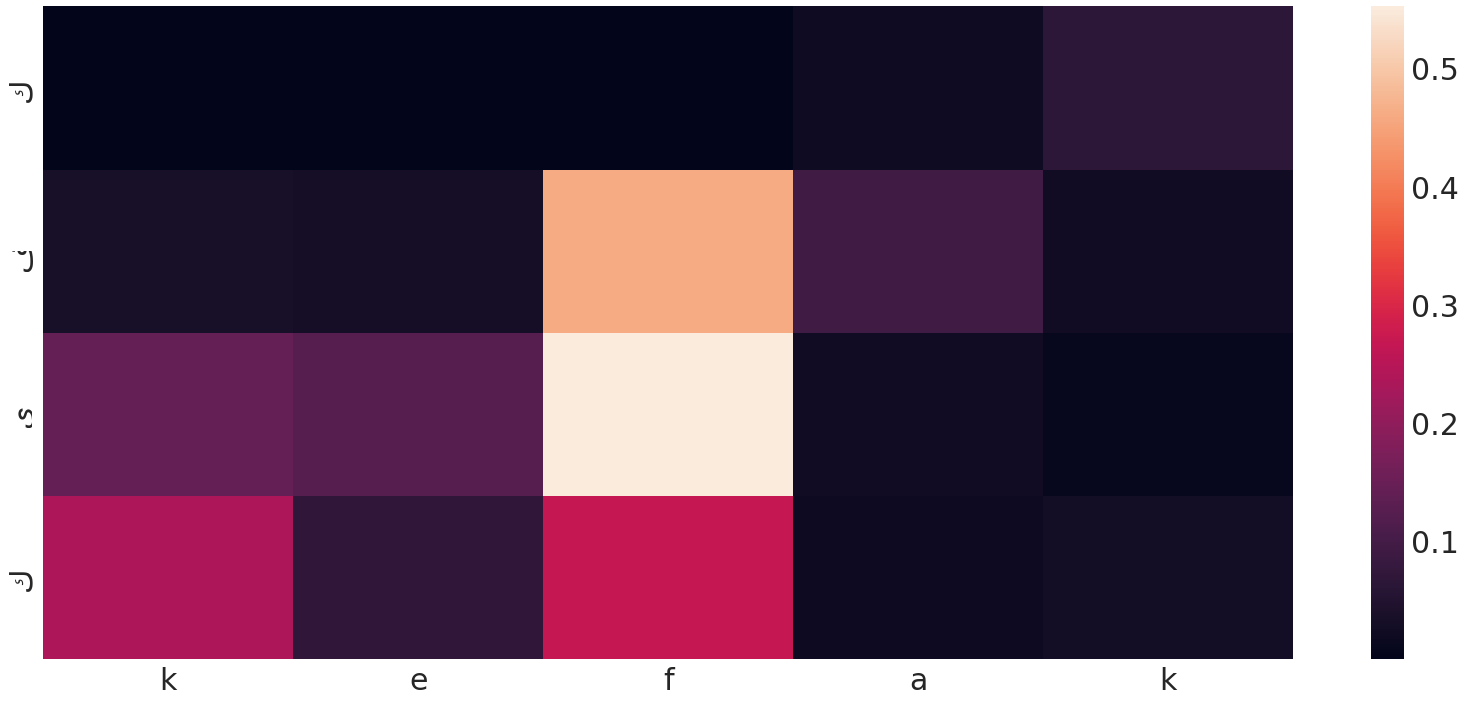

In [ ]:
visualize('kefak')
